# EOSUSDT：binance品种测试

# 一、alpha7因子

In [1]:
import warnings

warnings.filterwarnings('ignore')

时间频率为四小时，品种为EOS期货

In [2]:
from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
## 加freq参数

start = time()
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': 'EOSUSDT:binance', 'freq': '4H',
         'start_date':20180101000000}

Time_dict = ds.bar_reader(path,props)
print(time()-start)

4.969719886779785


In [3]:
from jaqs_fxdayu.data.hf_dataview import HFDataView
dv = HFDataView()

In [4]:
dv.create_init_dv(Time_dict.set_index(["trade_date","symbol"]))

Initialize dataview success.


引入三十日MA均线指标

In [57]:
ma=dv.add_formula('ma','Ts_Mean(close,30)',add_data=True)

Field [ma] is overwritten.


In [58]:
import matplotlib.pyplot as plt
import talib as ta

def plot_chart(close,alpha,ma):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,8))
    ax.plot(close.iloc[-400:])
    ax.plot(ma.iloc[-400:])
    ax1.plot(alpha.iloc[-400:])
    # plt.savefig('good')
    plt.show()

获取因子alpha7数据

In [70]:
alpha7=dv.add_formula('alpha7_C','-1*If(Ts_Mean(volume,20)<volume, (-1*Ts_Rank(Abs(Delta(close,7)),60))*Sign(Delta(close,7)),-1)',add_data=True)

Field [alpha7_C] is overwritten.


绘制均线和价格以及因子图

In [71]:
alpha7_plot = dv.get_ts('alpha7_C', date_type='datetime')
close = dv.get_ts('close', date_type='datetime')
ma=dv.get_ts('ma', date_type='datetime')

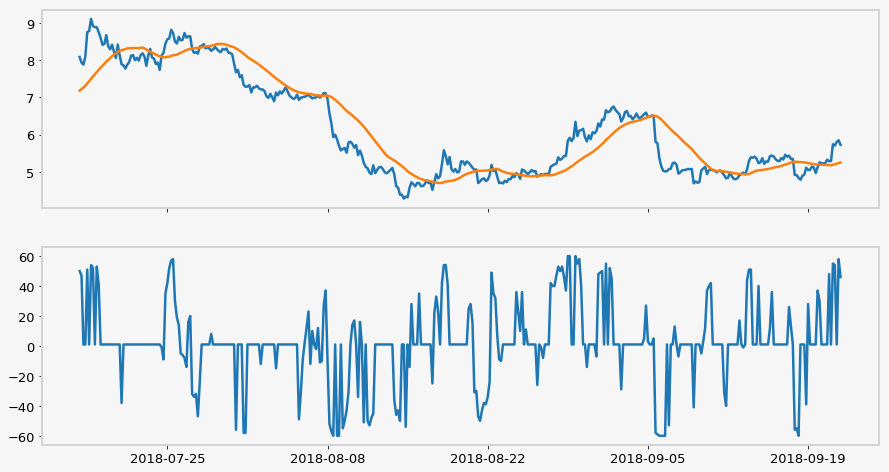

In [72]:
plot_chart(close, alpha7_plot,ma)

# 现象思考：
我们可以将alpha7因子数据分为三大类：

1.大于1

2.等于1

3.小于1

可以发现上升趋势的开始往往因子数据会出现大于1的情况，而在上升趋势中，由于短期价格波动导致因子数据回落到1，但趋势仍旧延续，所以因子数据由高处回落到1时并不意味着趋势结束。我们也会发现在上升趋势中因子数据出现1以下的情况短期趋势终止，盘面出现回调甚至反转。

基于以上发现总结，因子数据为1时代表行情的延续，在盘整情况下，因子出现偏离1的情况意味着趋势的开始，在趋势进行的过程中出现因子数据出现1的偏离方向和趋势方向相反，意味着趋势的结束。

# 信号假设

基于以上现象，我们将出入场信号的确定分为两个步骤：

1.趋势判定：

以四十日均线作为趋势判定线，收盘价在均线之上定义为上升趋势，收盘价在均线之下定义为下降趋势。

2.因子值判定
以偏离1的因子值作为趋势开启状态，以趋势反方向偏离1的因子值作为趋势结束状态。

信号如下：
多单开仓：在上升趋势的情况下，持仓为0并且因子值大于1.

空单开仓：在下降趋势的情况下，持仓为0并且因子值小于1.

平多单：收盘价触及均线或者因子值小于1.

平空单：收盘价触及均线或者因子值大于1.

In [62]:
# 5、设定进出场条件
long = dv.add_formula('long','If((close>ma) && (alpha7_C>1),2,0)', add_data=True)
short = dv.add_formula('short','If((close<ma) && (alpha7_C<1),-2,0)', add_data=True)
closeLong = dv.add_formula('closeLong','If((close<ma) ||(alpha7_C<1),1,0)', add_data=True)
closeShort = dv.add_formula("closeShort",'If((close>ma) ||(alpha7_C>1),-1,0)', add_data=True)

Field [long] is overwritten.
Field [short] is overwritten.
Field [closeLong] is overwritten.
Field [closeShort] is overwritten.


In [63]:
#6、计算绩效
from jaqs_fxdayu.research import TimingDigger

tdMaStatistic = TimingDigger(output_folder=".", output_format='pdf',signal_name='MaStatistic')

def TimingSignal(td, dv, mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称


    #多空分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts("long"),
        exit_signal=dv.get_ts("closeLong"),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts("short"),
        exit_signal=dv.get_ts("closeShort"),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )
TimingSignal(tdMaStatistic, dv, 100,sl=100,sp=100)

Nan Data Count (should be zero) : 0;  Percentage of effective data: 11%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 15%


In [64]:
tdMaStatistic.create_event_report(sig_type="long")

*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               6.215  -9.133   0.314
p-value              0.000   0.000   0.754
mean                 0.052  -0.042   0.002
std                  0.050   0.029   0.062
info_ratio           1.036  -1.426   0.036
skewness             0.742  -0.375   0.714
kurtosis            -0.889  -1.124   0.037
pct5                 0.002  -0.093  -0.087
pct25                0.006  -0.065  -0.040
pct50                0.036  -0.035  -0.003
pct75                0.101  -0.021   0.031
pct95                0.146  -0.003   0.133
occurance           37.000  42.000  79.000
win_ratio              NaN     NaN   0.468
win_mean/loss_mean     NaN     NaN   1.248


In [65]:
tdMaStatistic.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                       win    loss      all
t-stat               7.749  -9.019    0.715
p-value              0.000   0.000    0.476
mean                 0.056  -0.031    0.004
std                  0.047   0.028    0.057
info_ratio           1.196  -1.136    0.069
skewness             0.936  -2.145    0.758
kurtosis            -0.123   7.430    1.255
pct5                 0.006  -0.081   -0.066
pct25                0.022  -0.046   -0.029
pct50                0.039  -0.026   -0.007
pct75                0.090  -0.013    0.030
pct95                0.158  -0.002    0.107
occurance           43.000  64.000  107.000
win_ratio              NaN     NaN    0.402
win_mean/loss_mean     NaN     NaN    1.800


In [66]:
tdMaStatistic.create_event_report(sig_type="long_short")#同时计算多空头信号的绩效

*****-Summary-*****
Event Analysis
                       win     loss      all
t-stat               9.933  -12.654    0.738
p-value              0.000    0.000    0.461
mean                 0.054   -0.035    0.003
std                  0.049    0.029    0.059
info_ratio           1.118   -1.235    0.054
skewness             0.827   -1.337    0.734
kurtosis            -0.510    2.828    0.653
pct5                 0.002   -0.087   -0.082
pct25                0.011   -0.053   -0.031
pct50                0.038   -0.028   -0.005
pct75                0.092   -0.014    0.031
pct95                0.149   -0.002    0.130
occurance           80.000  106.000  186.000
win_ratio              NaN      NaN    0.430
win_mean/loss_mean     NaN      NaN    1.535


# 二、DMI技术因子

In [115]:
import warnings

warnings.filterwarnings('ignore')

时间频率为四小时，品种为EOS期货

In [116]:
from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
## 加freq参数

start = time()
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': 'EOSUSDT:binance', 'freq': '4H',
         'start_date':20180101000000}

Time_dict = ds.bar_reader(path,props)
print(time()-start)

4.1449220180511475


In [117]:
from jaqs_fxdayu.data.hf_dataview import HFDataView
dv = HFDataView()

In [118]:
dv.create_init_dv(Time_dict.set_index(["trade_date","symbol"]))

Initialize dataview success.


In [119]:
close = dv.get_ts('close',date_type='datetime').dropna()
high = dv.get_ts('close',date_type='datetime').dropna()
low = dv.get_ts('close',date_type='datetime').dropna()

绘制DI+、DI-、ADX因子图

In [120]:
dm1=dv.add_formula('dm1','If((high-Delay(high,1))>0,high-Delay(high,1),0)',add_data=True)

In [121]:
dm2=dv.add_formula('dm2','If((Delay(low,1)-low)>0,Delay(low,1)-low,0)',add_data=True)

In [122]:
dm=dv.add_formula('dm','Max(dm1,dm2)',add_data=True)

In [123]:
tr1=dv.add_formula('TR1','Max(Abs(high-close),Abs(high-Delay(close,1)))',add_data=True)

In [124]:
tr2=dv.add_formula('TR2','Max(Abs(high-close),Abs(low-Delay(close,1)))',add_data=True)

In [125]:
tr=dv.add_formula('TR','Max(TR1,TR2)',add_data=True)

In [126]:
di1=dv.add_formula('DI1','Ts_Mean(dm1,14)*100/Ts_Mean(TR,14)',add_data=True)

In [127]:
di2=dv.add_formula('DI2','Ts_Mean(dm2,14)*100/Ts_Mean(TR,14)',add_data=True)

In [128]:
dx=dv.add_formula('DX','Abs(DI1-DI2)*100/(DI1+DI2)',add_data=True)

In [129]:
adx=dv.add_formula('ADX','Ts_Mean(DX,14)',add_data=True)

In [130]:
import matplotlib.pyplot as plt
import talib as ta

def plot_chart(close,di1,di2,adx):
    fig,(ax,ax1,ax2) = plt.subplots(3,1,sharex=True, figsize=(15,8))
    ax.plot(close.iloc[-450:])
    ax1.plot(di1.iloc[-450:])
    ax1.plot(di2.iloc[-450:])
    ax2.plot(adx.iloc[-450:])
    ax2.hlines(30,adx.index[-450],adx.index[-1])
    # plt.savefig('good')
    plt.show()

In [131]:
close = dv.get_ts('close', date_type='datetime')
di1=dv.get_ts('DI1', date_type='datetime')
di2=dv.get_ts('DI2', date_type='datetime')
adx=dv.get_ts('ADX', date_type='datetime')

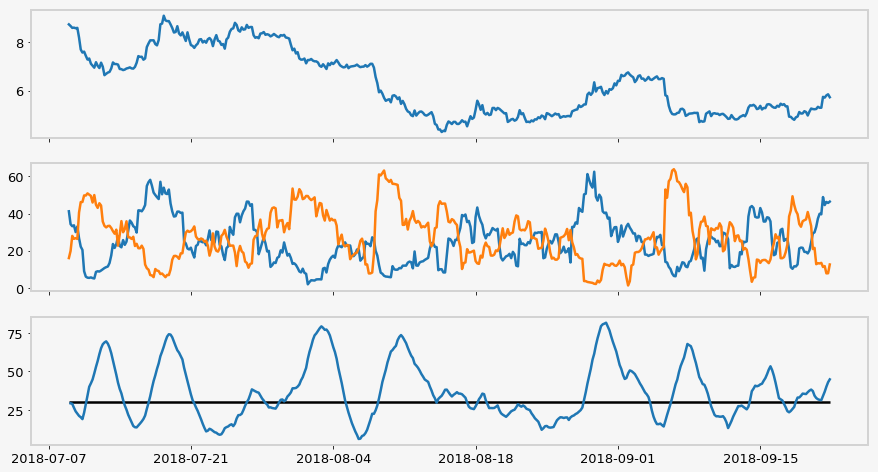

In [132]:
plot_chart(close,di1,di2,adx)

# 现象思考：
DMI指标的研判主要是集中在两个方面，一个方面是分析上升指标+DI、下降指标-DI和平均动向指标ADX之间的关系，另一个方面是对行情的趋势及转势特征的判断。其中，+DI和-DI两条曲线的走势关系是判断能否买卖的信号，ADX则是判断未来行情发展趋势的信号。

1、判断行情趋势
当行情走势由横盘向上发展时，ADX值会不断递增。因此，当ADX值高于前一日时，可以判断当前市场行情仍在维持原有的上升趋势，即价格将继续上涨，如果+DI和﹣DI同时增加，则表明当前上升趋势将十分强劲。

当行情走势进入横盘阶段时，ADX值会不断递减。因此，判断行情时，应结合价格走势（+DI和-DI）走势进行判断。

当行情走势由盘整向下发展时，ADX值也会不断递增。因此，当ADX值高于前一日时，可以判断当前市场行情仍维持原有的下降趋势，即价格将继续下跌，如果+DI和-DI同时减少，则表示当前的跌势将延续。

2、判断行情是否盘整
当市场行情在一定区域内小幅横盘盘整时，ADX值会出现递减情况。当ADX值降至300以下，且呈横向窄幅移动时，可以判断行情为牛皮盘整，上升或下跌趋势不明朗，投资者应以观望为主，不可依据+DI和-DI的交叉信号来买卖。

3、判断行情是否转势
当ADX值在高点由升转跌时，预示行情即将反转。在涨势中的ADX在高点由升转跌，预示涨势即将告一段落；在跌势中的ADX值从高位回落，预示跌势可能停止。

# 信号假设

DMI因子信号判断分为两部分：

一、上升指标+DI和下降指标-DI的研判功能

1、当股价走势向上发展，而同时+DI从下方向上突破-DI时，表明市场上有新多买家进场，为买入信号，如果ADX伴随上升，则预示股价的涨势可能更强劲。

2、当股价走势向下发展时，而同时+DI从上向下突破-DI时，表明市场上做空力量在加强，为卖出信号，如果ADX伴随上升，则预示跌势将加剧。

3、当股价维持某种上升或下降行情时，+DI和﹣DI的交叉突破信号比较准确，但当股价维持盘整时，应将+DI和-DI交叉发出的买卖信号视为无效。

二、平均动向指标ADX的研判功能

ADX为动向值DX的平均数，而DX是根据+DI和-DI两数值的差和对比计算出来的百分比，因此，利用ADX指标将更有效地判断市场行情的发展趋势。

信号如下：
多单开仓：+DI从下方向上突破-DI时，持仓为0并且ADX值高于前一日.

空单开仓：-DI从下方向上突破+DI时，持仓为0并且ADX值高于前一日.

平多单：-DI从下方向上突破+DI.

平空单：+DI从下方向上突破-DI.


In [133]:
# 5、设定进出场条件
long = dv.add_formula('long','If((DI1>DI2) && (ADX>Delay(ADX,1)),2,0)', add_data=True)
short = dv.add_formula('short','If((DI2>DI1) && (ADX>Delay(ADX,1)),-2,0)', add_data=True)
closeLong = dv.add_formula('closeLong','If((DI1<DI2),1,0)', add_data=True)
closeShort = dv.add_formula("closeShort",'If((DI1>DI2),-1,0)', add_data=True)

In [134]:
#6、计算绩效
from jaqs_fxdayu.research import TimingDigger

tdMaStatistic = TimingDigger(output_folder=".", output_format='pdf',signal_name='MaStatistic')

def TimingSignal(td, dv, mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称


    #多空分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts("long"),
        exit_signal=dv.get_ts("closeLong"),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts("short"),
        exit_signal=dv.get_ts("closeShort"),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )
TimingSignal(tdMaStatistic, dv, 100,sl=100,sp=100)

Nan Data Count (should be zero) : 0;  Percentage of effective data: 19%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 24%


In [135]:
tdMaStatistic.create_event_report(sig_type="long")

*****-Summary-*****
Event Analysis
                       win    loss      all
t-stat               9.730 -13.098    0.811
p-value              0.000   0.000    0.419
mean                 0.094  -0.047    0.006
std                  0.068   0.033    0.084
info_ratio           1.376  -1.438    0.070
skewness             0.592  -0.805    0.947
kurtosis            -0.370  -0.619    0.399
pct5                 0.002  -0.113   -0.106
pct25                0.040  -0.071   -0.042
pct50                0.091  -0.036   -0.020
pct75                0.122  -0.022    0.057
pct95                0.227  -0.010    0.191
occurance           51.000  84.000  135.000
win_ratio              NaN     NaN    0.378
win_mean/loss_mean     NaN     NaN    1.977


In [136]:
tdMaStatistic.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                        win    loss      all
t-stat               11.074  -8.810    3.662
p-value               0.000   0.000    0.000
mean                  0.063  -0.042    0.020
std                   0.057   0.039    0.072
info_ratio            1.113  -1.076    0.283
skewness              0.754  -1.638    0.307
kurtosis             -0.759   3.086    0.221
pct5                  0.003  -0.101   -0.086
pct25                 0.017  -0.056   -0.022
pct50                 0.039  -0.030    0.009
pct75                 0.114  -0.013    0.053
pct95                 0.160  -0.002    0.157
occurance           100.000  68.000  168.000
win_ratio               NaN     NaN    0.595
win_mean/loss_mean      NaN     NaN    1.493


In [137]:
tdMaStatistic.create_event_report(sig_type="long_short")#同时计算多空头信号的绩效

*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat               14.389  -15.392    3.104
p-value               0.000    0.000    0.002
mean                  0.073   -0.045    0.014
std                   0.062    0.036    0.078
info_ratio            1.175   -1.253    0.179
skewness              0.762   -1.251    0.621
kurtosis             -0.298    1.573    0.232
pct5                  0.002   -0.113   -0.095
pct25                 0.019   -0.069   -0.033
pct50                 0.055   -0.033   -0.000
pct75                 0.117   -0.019    0.054
pct95                 0.192   -0.006    0.159
occurance           151.000  152.000  303.000
win_ratio               NaN      NaN    0.498
win_mean/loss_mean      NaN      NaN    1.628
